# Glimpse command console data analysis

This is an example to show how the command console data can be analaysed. In this way, we show how to set up a system such that the user can get notified when the glider is outside the transect. 

This example shows data from a local folder and in case the user wants to automatize it, it would then need to be sure these files are constantly sent by Glimpse and the code can run automatically (crontab job)

In [3]:
from io import StringIO
from shapely.geometry import LineString
from shapely.geometry import Polygon
from glob import glob
from matplotlib import style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
import subprocess
import pathlib
import logging
import os
import tqdm
import json 

#### Specify location of the command console data and other necessary files

In [4]:
loc = 'C:/Users/monfo/OneDrive/Desktop/VOTO/CMD_data/glimpse-data/'
# not sender = "/home/chiara/pilot_scripts/send_mail.sh"
# mission_WP = json.load(open('/home/chiara/pilot_scripts/mission_wp.json'))
# mails = open('/home/chiara/pilot_scripts/mail_list.txt').read().split(",") 

## Laod the command console data 

* 1) Enter every folder in this directory (each folder is a glider) and open the folder with the highest number, ie latest mission available for that glider.
* 2) Once we get access to the lastest mission, check if the g-log folder exixts and if it does, then check if there is data in the last 24h or not
* 2) If there is data from the last 24h, then we consider that an active mission and we want to analyse it


In [5]:
active_mission = []
for gli in glob(f"{loc}*", recursive=True):
    gli_missions = glob(f"{gli}/*", recursive=True)
    max_mission = max(gli_missions)
    log_data = list(pathlib.Path(f'{max_mission}/G-Logs').glob('*.com.raw.log'))
    if len(log_data) == 0:  # In case the g-log does not exist (rsync from Alseamar was rather recent)
        continue
    cmd_data = pd.read_csv(log_data[0], sep=";", header=0)
    cmd_data.DATE_TIME = pd.to_datetime(cmd_data.DATE_TIME, dayfirst=True, yearfirst=False, )
    latest = cmd_data.where(cmd_data.DATE_TIME > datetime.datetime.now() - datetime.timedelta(hours=24)).dropna()
    if len(latest) > 0:
        active_mission.append(log_data[0])

In [6]:
active_mission

[WindowsPath('C:/Users/monfo/OneDrive/Desktop/VOTO/CMD_data/glimpse-data/SEA063/000067/G-Logs/sea063.67.com.raw.log'),
 WindowsPath('C:/Users/monfo/OneDrive/Desktop/VOTO/CMD_data/glimpse-data/SEA066/000052/G-Logs/sea066.52.com.raw.log'),
 WindowsPath('C:/Users/monfo/OneDrive/Desktop/VOTO/CMD_data/glimpse-data/SEA069/000021/G-Logs/sea069.21.com.raw.log'),
 WindowsPath('C:/Users/monfo/OneDrive/Desktop/VOTO/CMD_data/glimpse-data/SEA076/000021/G-Logs/sea076.21.com.raw.log')]

The way the commands look like when loaded as pandas dataframes is as follows

In [7]:
pd.read_csv(active_mission[0], sep=";", header=0)

,DATE_TIME,LOG_LEVEL,MODULE,EMITTER/RECEIVER,ID_GLIDER,LOG_MSG
0,13.11.2023 13:58:28.438,INFO,module-IrisCom,Iridium,SEA063,Glider Connected !
1,13.11.2023 13:58:28.438,TRACE,module-IrisCom,Glider,SEA063,112
2,13.11.2023 13:58:28.438,TRACE,module-IrisCom,Glider,SEA063,done (a): Waiting for RESUME
3,13.11.2023 13:58:28.438,TRACE,module-IrisCom,Glider,SEA063,"$SEAMRS,SEA063,67,1,0,292,131123,135820,5534.2..."
4,13.11.2023 13:58:28.438,TRACE,module-IrisCom,Glider,SEA063,"$SEANAV,1,-9999,1020,-102"
...,...,...,...,...,...,...
6446,23.11.2023 07:16:41.516,TRACE,module-IrisCom,Glider,SEA063,"$SEADRK,0,5529.273,1613.393,0.00,2013,0.32,270..."
6447,23.11.2023 07:16:41.516,TRACE,module-IrisCom,Glider,SEA063,$go;
6448,23.11.2023 07:16:41.531,TRACE,module-IrisCom,Glider,SEA063,>cmd: $go
6449,23.11.2023 07:16:49.047,TRACE,module-IrisCom,Glider,SEA063,done (a): Waiting for GO


We therefore want to separate the info contained in the 'LOG_MSG' column in order to easily sort the vaious NMEA sentences and the info contained

### Create a dataframe for the glider data from the command console 
For each active mission we create a pandas dataframe with timestamp, latitude, longitude and the cycle number

In [8]:
def load_cmd(path):
    df = pd.read_csv(path, sep=";", header=0)
    a = df['LOG_MSG'].str.split(',', expand=True)
    cmd = pd.concat([df, a], axis=1)

    # Transform time from object to datetime
    cmd.DATE_TIME = pd.to_datetime(cmd.DATE_TIME, dayfirst=True, yearfirst=False, )
    # Add cycle
    cmd['cycle'] = cmd.where(cmd[0] == '$SEAMRS').dropna(how='all')[3]
    # create lat lon columns in decimal degrees
    cmd['lat'] = cmd.where(cmd[0] == '$SEAMRS').dropna(how='all')[8].str.rsplit('*').str[0]
    cmd['lon'] = cmd.where(cmd[0] == '$SEAMRS').dropna(how='all')[9].str.rsplit('*').str[0]
    cmd['lat'] = cmd.where(cmd[0] == '$SEAMRS').dropna(how='all').lat.replace('', np.nan).dropna(how='all').astype(float)
    cmd['lon'] = cmd.where(cmd[0] == '$SEAMRS').dropna(how='all').lon.replace('', np.nan).dropna(how='all').astype(float)
    
    #The SEAMRS nmea sentence prints the coordinates in ddmm.mmm so we what to transform them into dd.dddd
    def dd_coord(x):
        degrees = x // 100
        minutes = x - 100 * degrees
        res = degrees + minutes / 60
        return res

    df_glider = pd.DataFrame({"time": cmd.dropna(subset=['lon', 'lat']).DATE_TIME,
                              "lon": dd_coord(cmd['lon'].dropna().astype(float).values),
                              "lat": dd_coord(cmd['lat'].dropna().astype(float).values),
                              "cycle": cmd.dropna(subset=['lon', 'lat']).cycle})
    return df_glider

This way, the dataset would now look like this:

In [9]:
active_m1 = load_cmd(active_mission[0])
active_m1

,time,lon,lat,cycle
3,2023-11-13 13:58:28.438,16.351233,55.570583,1
8,2023-11-13 13:58:28.876,16.351250,55.570567,1
12,2023-11-13 13:58:43.391,16.351267,55.570533,1
20,2023-11-13 14:01:44.449,16.351433,55.570533,1
25,2023-11-13 14:01:44.840,16.351450,55.570533,1
...,...,...,...,...
6388,2023-11-23 07:14:34.331,16.223633,55.487967,439
6396,2023-11-23 07:14:54.315,16.223550,55.487950,439
6412,2023-11-23 07:15:44.345,16.223367,55.487917,439
6423,2023-11-23 07:15:58.314,16.223333,55.487933,439


### Defining the transect
We create a dictionary containing the waypoints of the transect so that we can understand if the glider is in or off the transect. We use the info contained in this dataframe, combined with the glider data to understand which transect the glider is in

In [10]:
mission_WP = { "SAMBA_01": {
                "names": [ "K11", "K6","K14", "K7_19000", "K15", "K13","K13_7500", "K11"],
                "lon": [11.3301, 11.0436,10.863,11.0280,11.1224,11.1277,11.1833,11.3301],
                "lat": [57.8032, 58.1167, 58.1038, 57.9312, 57.8894, 57.8537, 57.7939,57.8032]},
              'SAMBA_02':{
                 'names': ['B2','B4'], 
                 'lon': [15.9833, 16.3514],
                 'lat':[ 55.2500,55.5707 ]},
             'SAMBA_03':{
                 'names': ['G8','G2', 'G4'], 
                 'lon': [19.9293,19.9617, 19.7847],
                 'lat':[ 58.1474,58.2551, 58.5162]},
             'SAMBA_04':{'names': ['L1','L2', 'L3'],
                 'lon': [18.9567, 18.8812, 18.2013],
                 'lat': [58.1620, 58.4443, 58.5913]}, 
             'SAMBA_05':{
                 'names': ['A1', 'A2'],
                 'lon': [19.6948, 19.3669],
                 'lat': [60.0003, 60.1165]}}

In [14]:
def find_area(ds, plot=False, ax = None):
    for key in mission_WP.keys():
        polygon_geom = LineString(list(zip(mission_WP[key]['lon'], mission_WP[key]['lat'])))
        df_polytra = pd.DataFrame()
        poly_tran = gpd.GeoDataFrame(df_polytra, crs='epsg:4326', geometry=[polygon_geom,]).to_crs('epsg:3006').buffer(5000)
        buffer_poly= gpd.GeoDataFrame(geometry=poly_tran).to_crs('epsg:3006')

        geo_glider = gpd.GeoDataFrame(ds, geometry=gpd.points_from_xy(ds.lon, ds.lat))
        geo_glider = geo_glider.set_crs(epsg=4326).to_crs('epsg:3006')

        polygons_contains = gpd.sjoin(buffer_poly, geo_glider, predicate='contains')
        
        if plot == True:
            buffer_poly.plot(ax=ax,edgecolor='k', alpha=0.5)
            geo_glider.geometry.plot(ax=ax)
        
        if len(polygons_contains) !=0:
            area = key
    return area

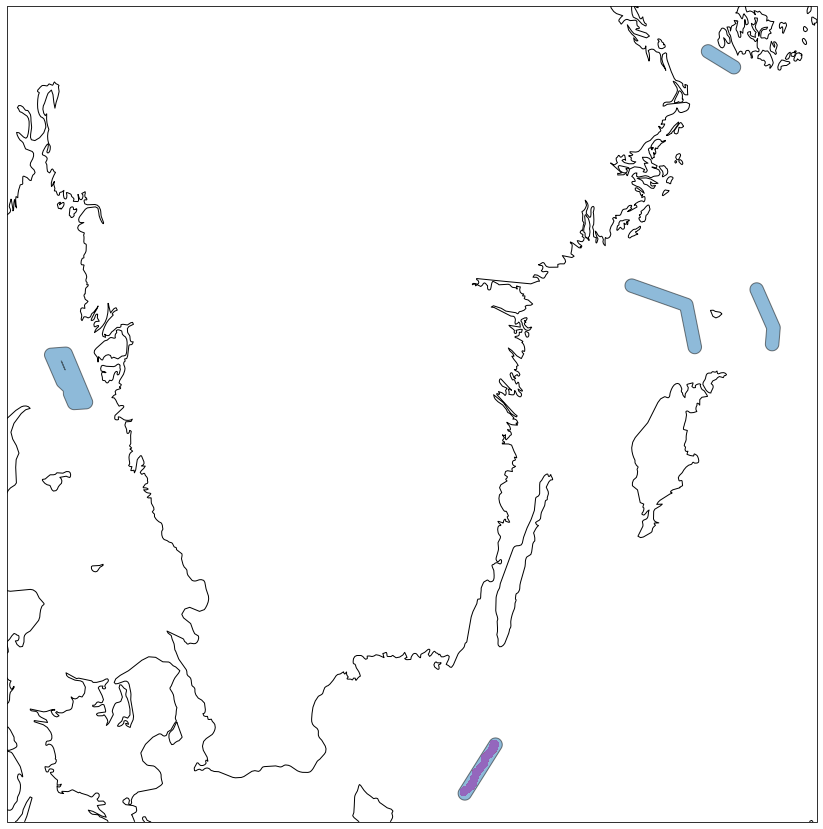

In [104]:
fig = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.epsg('3006'))
find_area(active_m1, plot=True, ax = ax)
ax.coastlines()

### Understand if the glider is on the trasnect or not
Once we have identified the transect, we want to analyse only the last 12h of data and see if the glider is on the transect within a buffer limit of 1.5km

In [79]:
def find_if_on_transect(ds, buff_lim=1500, time_lim=40, plot=False, ax =ax):
    st_area = find_area(ds)
    lineStringObj = LineString(list(zip(mission_WP[st_area]['lon'], mission_WP[st_area]['lat'])))
    df_tra = pd.DataFrame()
    df_tra['LineID'] = [101, ]
    line_tran = gpd.GeoDataFrame(df_tra, crs='epsg:4326', geometry=[lineStringObj, ]).to_crs('epsg:3006').buffer(buff_lim) # this coordinate system is suitable for Sweden
    buffer_df = gpd.GeoDataFrame(geometry=line_tran).to_crs('epsg:3006')

    sub_glider = ds.where(ds.time > datetime.datetime.now() - datetime.timedelta(hours=time_lim)).dropna()
    sub_mean = sub_glider.groupby('cycle').mean()
    geo_glider = gpd.GeoDataFrame(sub_mean, geometry=gpd.points_from_xy(sub_mean.lon, sub_mean.lat))
    geo_glider = geo_glider.set_crs(epsg=4326).to_crs('epsg:3006')

    polygons_contains = gpd.sjoin(buffer_df, geo_glider, predicate='contains')

    cycle_on = polygons_contains.index_right
    all_cycle = sub_glider.cycle.unique()
    distance = geo_glider.geometry.apply(lambda g: buffer_df.distance(g))
    cycles_off = all_cycle[np.where(np.isin(all_cycle, cycle_on) == False)]
    
    if plot == True:
            buffer_df.plot(ax=ax,edgecolor='k', alpha=0.5)
            geo_glider.geometry.plot(ax=ax)
            
    return cycles_off,  (distance.where(distance != 0).dropna()).astype(int)


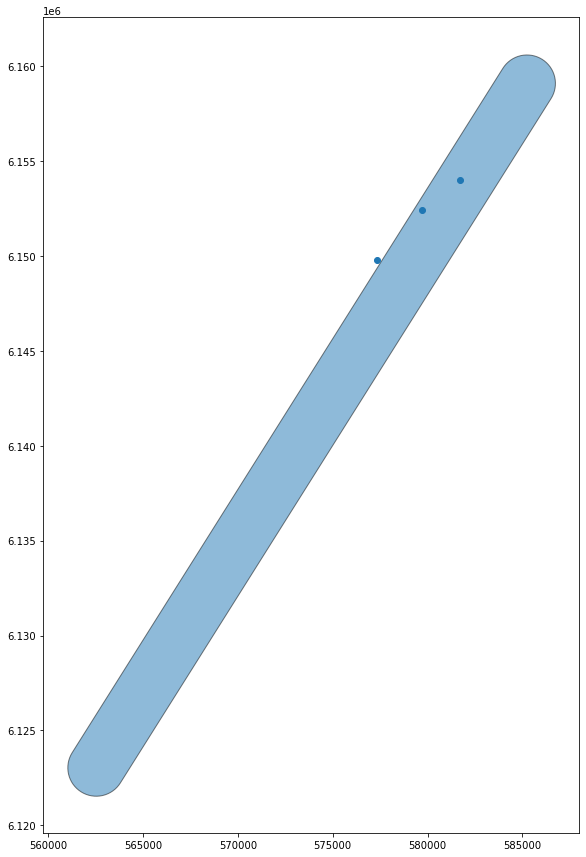

In [80]:
fig, ax = plt.subplots(1,1,figsize=(20, 15))
off_c, dist = find_if_on_transect(active_m1, buff_lim=1500, time_lim=12, plot=True, ax =ax)

This shows that the glider was off the buffer area only once, at cycle 439 by 202m

### Create a table to summarize the info from all the active missions

In [56]:
tab = pd.DataFrame(columns = ['glider','cycles_off', 'area', 'distance (m)'])
tab.glider = range(0,len(active_mission))

for i in tqdm.tqdm(range(len(active_mission))):
    act1 = load_cmd(active_mission[i])
    glid_off, dist_tra = find_if_on_transect(act1, buff_lim=1500, time_lim=8)
    if len(glid_off) != 0:
        tab.loc[i, 'glider'] = str(active_mission[i])[:-12][-9:]
        tab.at[i, 'cycles_off'] = glid_off
        tab.loc[i, 'area'] = find_area(act1)
        tab.at[i, 'distance (m)'] = dist_tra.values.flatten()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.51s/it]


In [57]:
tab

,glider,cycles_off,area,distance (m)
0,sea063.67,[[439]],SAMBA_02,[203.0]
1,sea066.52,[[96]],SAMBA_04,[664.0]
2,sea069.21,"[[224, 235]]",SAMBA_01,"[2134.0, 2202.0]"
3,3,NaN,NaN,NaN
